In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [155]:
def load_dataset():
    df= pd.read_csv('https://drive.google.com/uc?id=1qVdE4PshjtnHt2NThURaM7ZZgw-9o1G7')
    return df
df = load_dataset()
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [156]:
def print_summarize_dataset(dataset):
    print('Dataset shape: ', dataset.shape, '\n\n')
    print('Dataset info:', dataset.info(), '\n\n')
    print('NaN values count:\n', dataset.isna().sum())
print_summarize_dataset(df)

Dataset shape:  (10841, 13) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Dataset info: None 


NaN values count:
 App                  0
Category             0
Rating            1474
Reviews              0

In [157]:
def clean_dataset(dataset):
    dataset.drop_duplicates('App', inplace=True)
    dataset.drop(['Last Updated', 'Current Ver'], axis=1, inplace=True)
    dataset.dropna(axis = 0, inplace = True)
    dataset["Reviews"] = dataset["Reviews"].astype(int)
    dataset_size = dataset[dataset["Size"].str.contains("k", regex = False)]
    dataset_size["Size"] = dataset_size["Size"].str.replace("k", "", regex = False).astype(float)/1000
    df["Size"].update(dataset_size["Size"])
    dataset["Size"] = dataset["Size"].str.replace("Varies with device", "NaN", regex = False).str.replace("M", "").astype(float)
    dataset["Installs"] = dataset["Installs"].str.replace("+", "").str.replace(",", "", regex = False).astype(int)
    dataset["Price"] = dataset["Price"].str.replace("$", "", regex = False).astype(float)
    dataset["Content Rating"] = dataset["Content Rating"].str.replace("Everyone +10", "Everyone", regex = False).str.replace("+", "")
    dataset.reset_index(drop=True, inplace=True)
    return dataset
cleaned_data = clean_dataset(df)
cleaned_data

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...
8189,FR Calculator,FAMILY,4.0,7,2.6,500,Free,0.0,Everyone,Education,4.1 and up
8190,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000,Free,0.0,Everyone,Education,4.1 and up
8191,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100,Free,0.0,Everyone,Education,4.1 and up
8192,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,1000,Free,0.0,Mature 17,Books & Reference,Varies with device


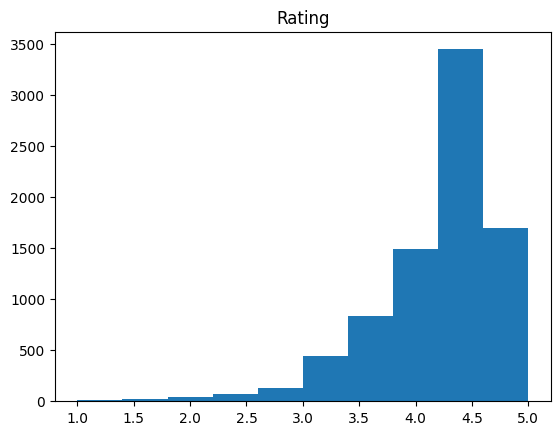

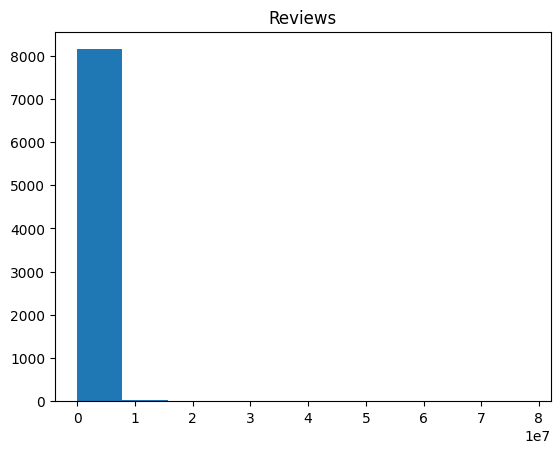

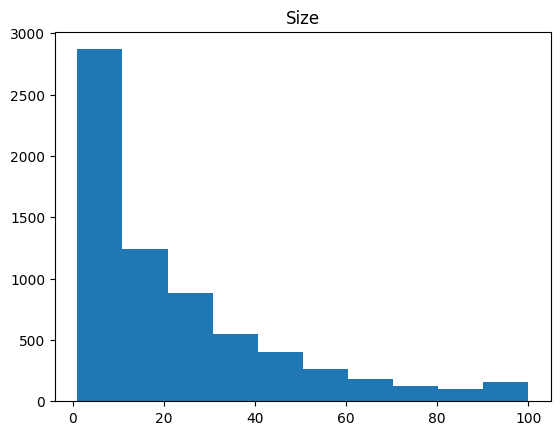

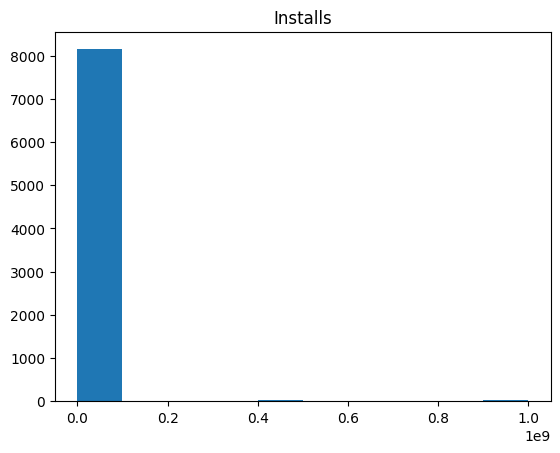

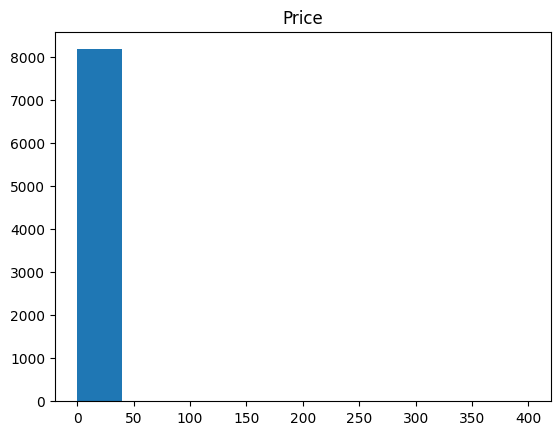

In [158]:
def print_histograms(dataset):
    s = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']
    for i in s:
        plt.hist(dataset[i])
        plt.title(i)
        plt.show()
hist = print_histograms(cleaned_data)


In [159]:
def compute_correlations_matrix(dataset):
    return dataset.corr(numeric_only=True)
cor = compute_correlations_matrix(df)
cor

,Rating,Reviews,Size,Installs,Price
Rating,1.000000,0.055099,0.054914,0.040165,-0.021196
Reviews,0.055099,1.000000,0.178759,0.624054,-0.007788
Size,0.054914,0.178759,1.000000,0.128733,-0.024954
Installs,0.040165,0.624054,0.128733,1.000000,-0.009653
Price,-0.021196,-0.007788,-0.024954,-0.009653,1.000000


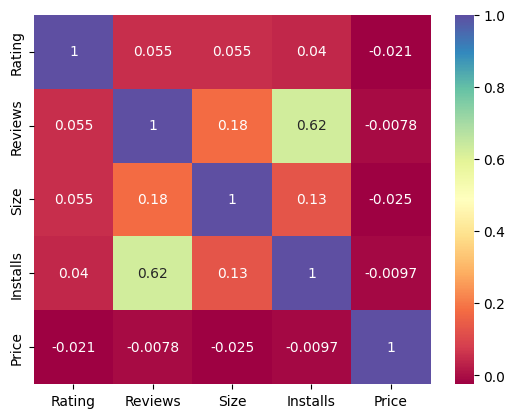

In [160]:
def print_scatter_matrix():
    sns.heatmap(cor, annot = True, cmap = 'Spectral')
    plt.show()
scatter = print_scatter_matrix()


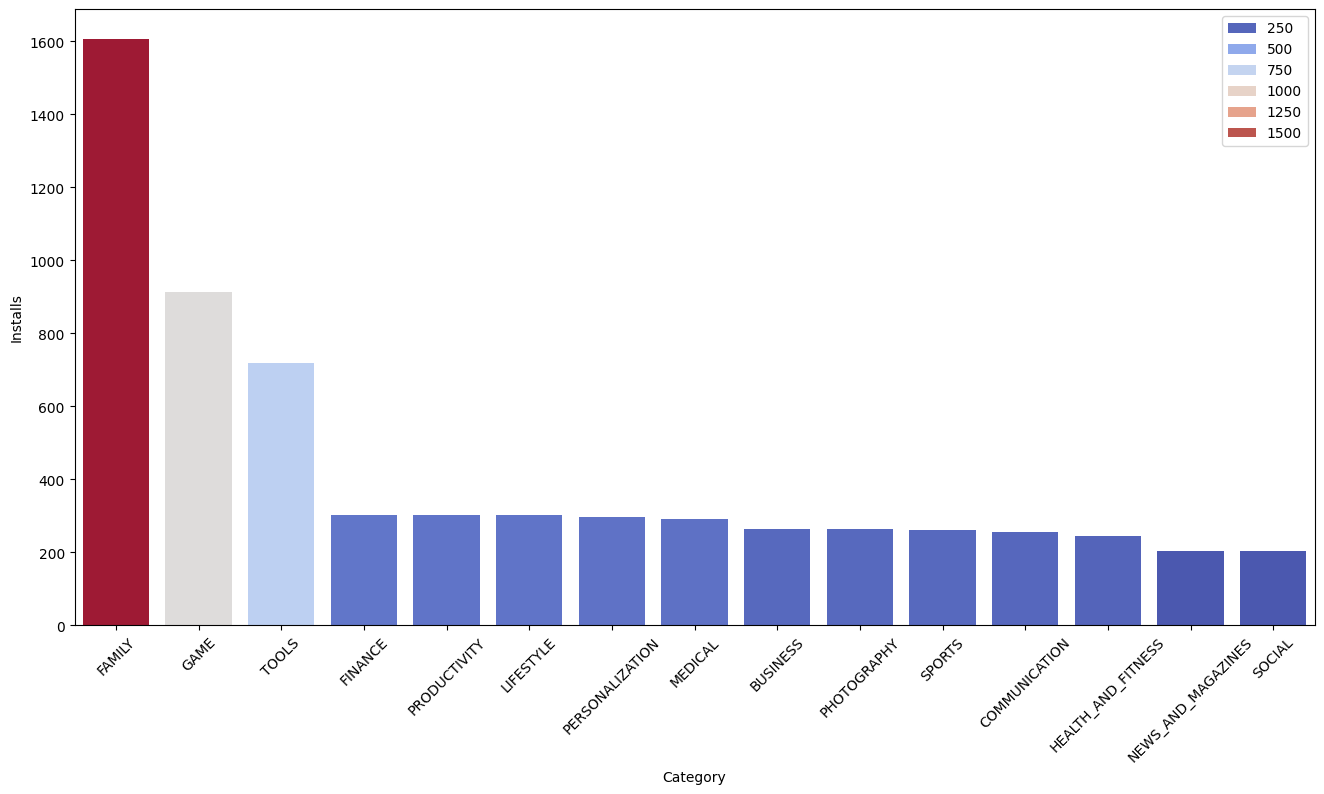

In [161]:
group = cleaned_data['Category'].value_counts()[:15]
plt.figure(figsize=(16, 8))
sns.barplot(x=group.index, y=group.values, hue=group.values, palette=sns.color_palette("coolwarm", as_cmap=True))
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Installs')
plt.show()

<Figure size 640x480 with 0 Axes>

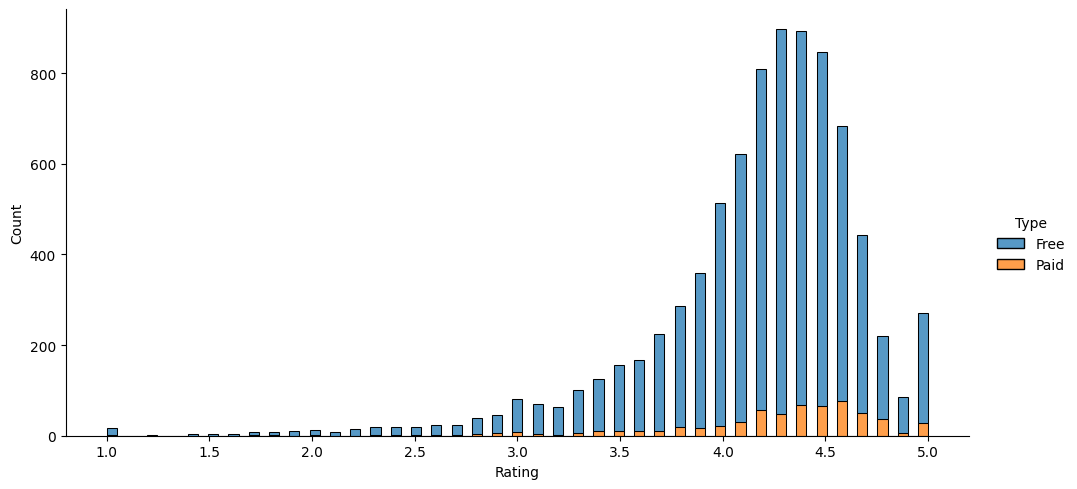

In [162]:
plt.figure()
sns.displot(data=cleaned_data, x='Rating', hue='Type', height=5, aspect=2, multiple="stack")
plt.show()

In [163]:
family_paid = cleaned_data[(cleaned_data.Category == 'FAMILY') & (cleaned_data.Type == 'Paid')]
family_paid

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
1530,Toca Mystery House,FAMILY,4.2,96,79.0,5000,Paid,3.99,Everyone,Educational;Creativity,4.4 and up
1552,My Little Princess : Stores,FAMILY,4.3,169,60.0,5000,Paid,2.99,Everyone,Educational;Pretend Play,4.1 and up
1553,Sago Mini Big City,FAMILY,4.2,8,44.0,1000,Paid,3.99,Everyone,Education;Pretend Play,4.4 and up
1554,Pinkalicious Party,FAMILY,3.0,2,82.0,500,Paid,2.99,Everyone,Educational;Creativity,4.1 and up
1603,Toca Builders,FAMILY,4.2,3328,NaN,100000,Paid,3.99,Everyone,Education;Creativity,Varies with device
...,...,...,...,...,...,...,...,...,...,...,...
7592,European War 6: 1804,FAMILY,4.2,1330,96.0,10000,Paid,0.99,Teen,Strategy,4.4 and up
7593,XCOM®: Enemy Within,FAMILY,4.2,13752,21.0,100000,Paid,9.99,Mature 17,Strategy,4.0 and up
7618,Deus Ex GO,FAMILY,4.5,9699,23.0,100000,Paid,0.99,Teen,Puzzle,4.2 and up
7941,SCI-FI UI,FAMILY,4.7,15,3.9,100,Paid,1.99,Everyone,Entertainment,1.6 and up


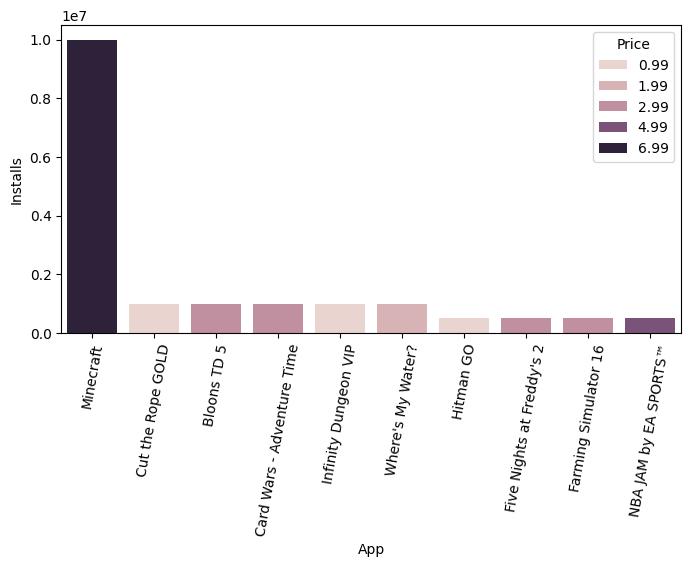

In [164]:
plt.figure(figsize=(8, 4))
sns.barplot(data=family_paid.sort_values('Installs', ascending=False)[:10], y='Installs', x='App', hue='Price')
plt.xticks(rotation=80)
plt.show()

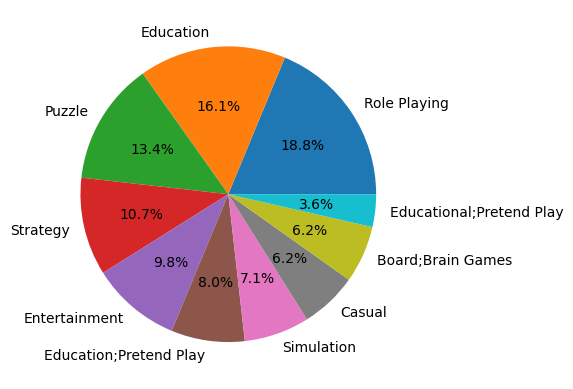

In [165]:
plt.figure()
plt.pie(family_paid.Genres.value_counts()[:10], labels=family_paid.Genres.value_counts().index[:10], autopct='%1.1f%%')
plt.show()

In [166]:
task_2 = family_paid.groupby('Genres').sum(numeric_only=True).sort_values('Installs', ascending=False)[:10]
task_2

,Rating,Reviews,Size,Installs,Price
Genres,,,,,
Arcade;Action & Adventure,12.4,2425960,35.3,10110000,9.97
Role Playing,88.7,174590,589.9,1992100,171.57
Puzzle,66.0,193606,375.6,1990560,35.06
Strategy,53.2,295464,380.3,1895500,42.38
Puzzle;Brain Games,9.3,204041,87.0,1100000,4.98
Card;Action & Adventure,4.3,129603,23.0,1000000,2.99
Sports;Action & Adventure,8.4,60307,84.0,600000,7.98
Simulation;Education,4.2,32812,14.0,500000,2.99
Educational;Pretend Play,16.6,5303,240.0,165000,11.96


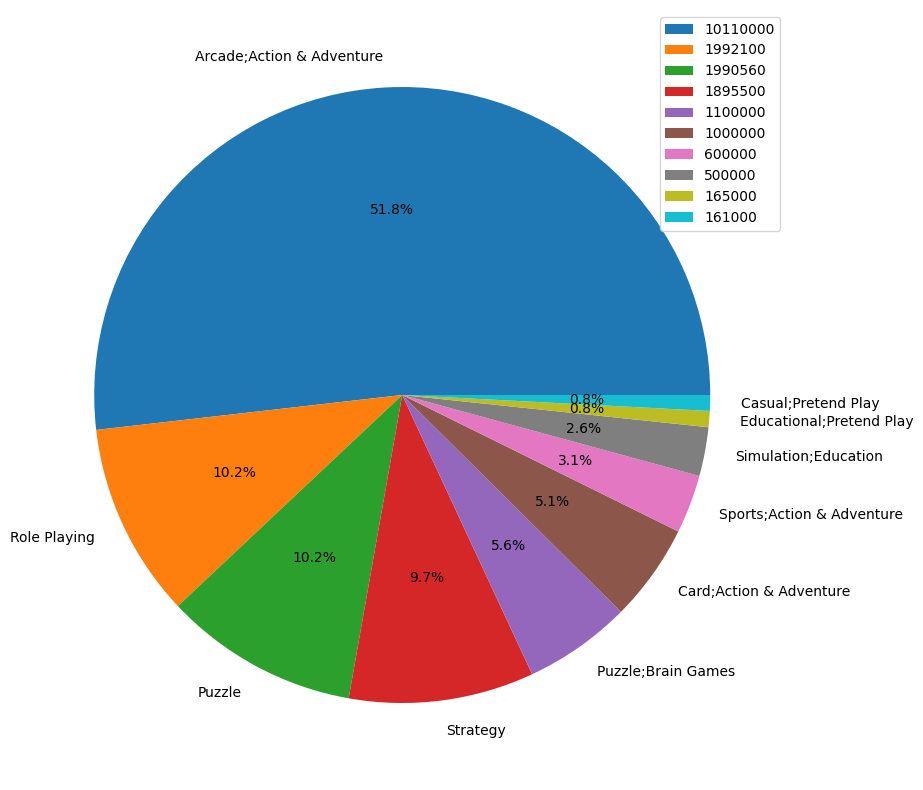

In [167]:
plt.figure(figsize=(20, 10))
plt.pie(task_2.Installs, labels=task_2.index, autopct='%1.1f%%')
plt.legend(task_2.Installs, loc="upper right")
plt.show()

In [168]:
task_3 = cleaned_data.groupby('Category').sum(numeric_only=True).sort_values('Installs', ascending=False)
task_3['Installs']

Category
GAME                   13878762717
COMMUNICATION          11038241530
TOOLS                   7999724500
PRODUCTIVITY            5793070180
SOCIAL                  5487841475
PHOTOGRAPHY             4649143130
FAMILY                  4427479590
VIDEO_PLAYERS           3926797200
TRAVEL_AND_LOCAL        2894859300
NEWS_AND_MAGAZINES      2369110650
ENTERTAINMENT           2113660000
BOOKS_AND_REFERENCE     1665791655
PERSONALIZATION         1532341930
SHOPPING                1400331540
HEALTH_AND_FITNESS      1144006220
SPORTS                  1096431465
BUSINESS                 697018120
LIFESTYLE                503741120
MAPS_AND_NAVIGATION      503267560
FINANCE                  455312400
WEATHER                  361096500
EDUCATION                352852000
FOOD_AND_DRINK           211677750
DATING                   140912410
ART_AND_DESIGN           114233100
HOUSE_AND_HOME            97082000
AUTO_AND_VEHICLES         53129800
LIBRARIES_AND_DEMO        52083000
COMICS     

In [169]:
task_3

,Rating,Reviews,Size,Installs,Price
Category,,,,,
GAME,3873.6,622295937,35674.2,13878762717,277.37
COMMUNICATION,1055.1,285810907,2236.8,11038241530,56.69
TOOLS,2900.4,229355702,5170.1,7999724500,207.90
PRODUCTIVITY,1259.2,55590391,2683.6,5793070180,70.92
SOCIAL,862.2,227927470,2700.0,5487841475,1.98
PHOTOGRAPHY,1093.4,105351227,3219.6,4649143130,72.31
FAMILY,6720.9,143822304,43797.9,4427479590,2261.82
VIDEO_PLAYERS,598.6,67484072,1772.9,3926797200,10.46
TRAVEL_AND_LOCAL,761.0,26819594,3492.9,2894859300,37.49


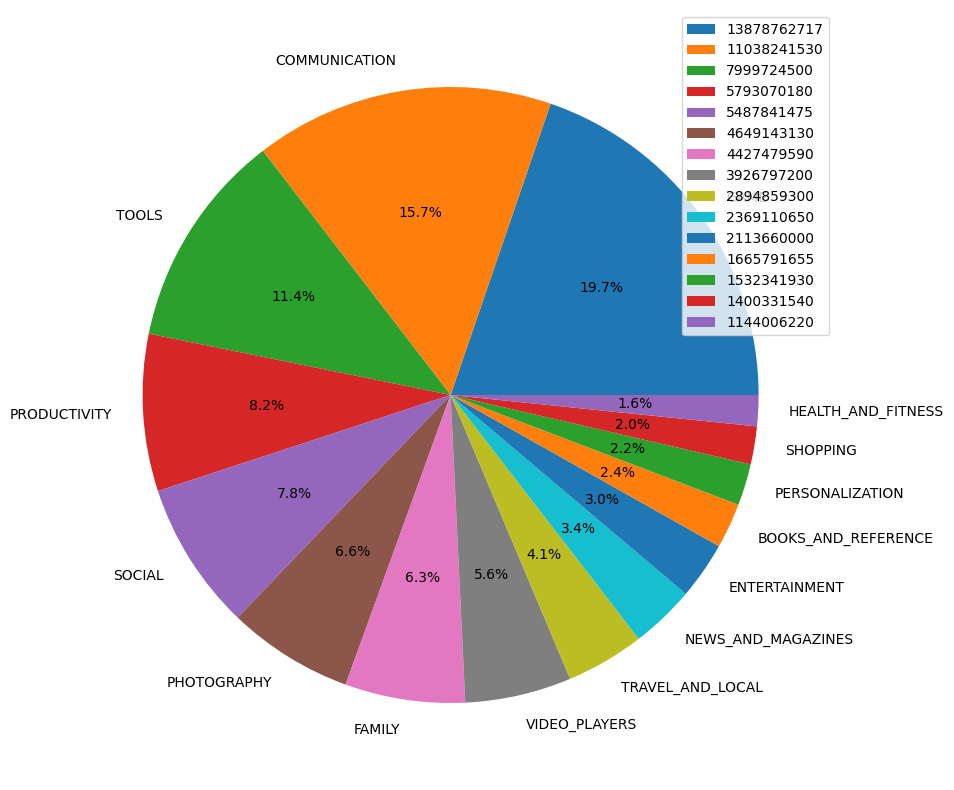

In [170]:
plt.figure(figsize=(10, 10))
plt.pie(task_3.Installs[:15], labels=task_3.index[:15], autopct='%1.1f%%')
plt.legend(task_3.Installs[:15])
plt.show()

In [171]:
task_4 = cleaned_data[cleaned_data['Type'] == 'Paid'].groupby('Category').mean(numeric_only=True).sort_values('Price', ascending=False)
task_4

,Rating,Reviews,Size,Installs,Price
Category,,,,,
FINANCE,3.830769,1784.461538,11.630000,14276.923077,187.682308
LIFESTYLE,4.250000,2634.555556,12.853333,65506.111111,108.937778
FAMILY,4.283766,23587.337662,28.817021,134070.324675,14.687143
MEDICAL,4.234921,315.634921,20.637500,8849.206349,9.902698
BUSINESS,4.077778,2791.444444,12.325000,23628.888889,7.156667
DATING,3.433333,534.666667,11.600000,3700.000000,6.323333
MAPS_AND_NAVIGATION,3.860000,1437.600000,21.650000,24220.000000,5.390000
PHOTOGRAPHY,4.013333,7681.600000,9.008333,125234.666667,4.820667
PARENTING,3.350000,4183.000000,8.300000,25050.000000,4.790000


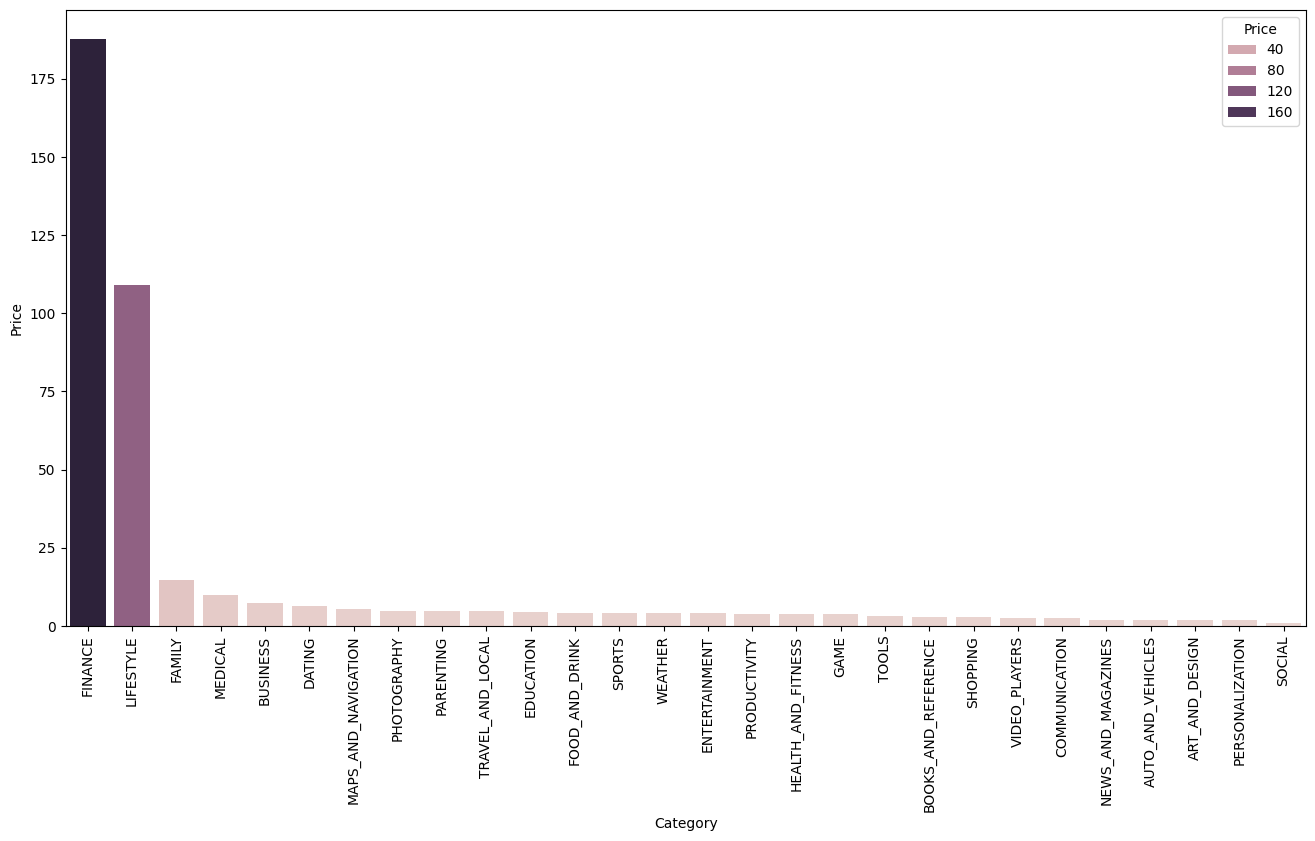

In [172]:
plt.figure(figsize=(16, 8))
sns.barplot(task_4, x='Category', y='Price', hue='Price')
plt.xticks(rotation=90)
plt.show()

In [173]:
task_last = cleaned_data[cleaned_data['Type'] == 'Paid'].groupby('Category').max().sort_values('Price', ascending=False)
task_last

,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
Category,,,,,,,,,,
LIFESTYLE,💎 I'm rich,5.0,23966,48.0,1000000,Paid,400.00,Teen,Lifestyle,Varies with device
FAMILY,"sugar, sugar",5.0,2376564,96.0,10000000,Paid,399.99,Teen,Strategy;Action & Adventure,Varies with device
FINANCE,Ray Financial Calculator Pro,4.7,19784,41.0,100000,Paid,399.99,Teen,Finance,4.4 and up
MEDICAL,palmPEDi: Pediatric Tape,5.0,4207,100.0,100000,Paid,79.99,Teen,Medical,Varies with device
SPORTS,iHunter BC,4.7,129409,73.0,1000000,Paid,29.99,Everyone,Sports,Varies with device
PHOTOGRAPHY,Pocket AC,4.8,49553,48.0,1000000,Paid,19.99,Everyone,Photography,Varies with device
BUSINESS,TurboScan: scan documents and receipts in PDF,4.8,11442,39.0,100000,Paid,17.99,Everyone,Business,Varies with device
GAME,Zombie Avengers:(Dreamsky)Stickman War Z,5.0,408292,100.0,10000000,Paid,17.99,Teen,Strategy,Varies with device
TOOLS,iCam - Webcam Video Streaming,5.0,57076,35.0,1000000,Paid,14.99,Everyone,Tools,Varies with device


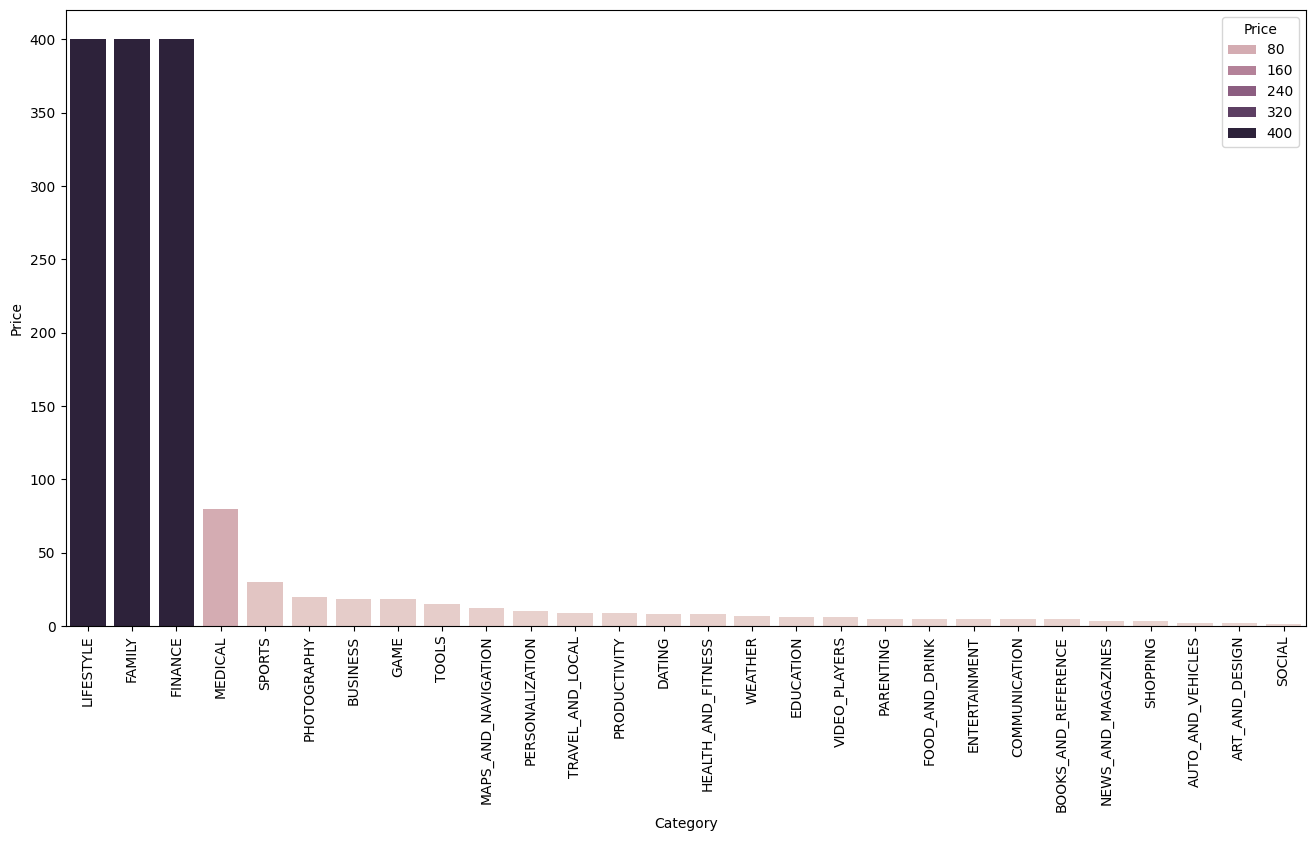

In [174]:
plt.figure(figsize=(16, 8))
sns.barplot(data=task_last, x=task_last.index, y='Price', hue='Price')
plt.xticks(rotation=90)
plt.show()